## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from copy import deepcopy
import joblib
import warnings
from datetime import datetime, timedelta

## Loading Dataset

In [2]:
weather_df = pd.read_csv("data/1990-2023-data.csv")
weather_df = weather_df.iloc[:, 1:]
weather_df.head(1)


,date,city_name,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,precipitation_forecast
0,01-01-1990,Chennai,27.35,22.3,24.595833,0.1,1,17.429354,30.960001,51.675465,3.471187,0.0


In [3]:
weather_df = weather_df[['date', 'city_name', 'precipitation_sum']]
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%d-%m-%Y')
weather_df.head(1)

,date,city_name,precipitation_sum
0,1990-01-01,Chennai,0.1


In [4]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211106 entries, 0 to 211105
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               211106 non-null  datetime64[ns]
 1   city_name          211106 non-null  object        
 2   precipitation_sum  211106 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.8+ MB


In [5]:
city_names = weather_df['city_name'].unique()
city_names

array(['Chennai', 'Mayiladuthurai', 'Thoothukudi', 'Nagercoil',
       'Thiruvananthapuram', 'Kollam', 'Kochi', 'Kozhikode', 'Kannur',
       'Visakhapatnam', 'Nellore', 'Mangaluru', 'Udupi', 'Mumbai',
       'Daman', 'Alappuzha', 'Kakinada'], dtype=object)

## Feature Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
weather_df['precipitation_sum'] = scaler.fit_transform(weather_df[['precipitation_sum']])
weather_df

,date,city_name,precipitation_sum
0,1990-01-01,Chennai,0.000225
1,1990-01-02,Chennai,0.000225
2,1990-01-03,Chennai,0.000000
3,1990-01-04,Chennai,0.000000
4,1990-01-05,Chennai,0.019093
...,...,...,...
211101,2023-12-27,Kakinada,0.000000
211102,2023-12-28,Kakinada,0.000000
211103,2023-12-29,Kakinada,0.000000
211104,2023-12-30,Kakinada,0.000000


In [120]:
joblib.dump(scaler, "MLmodel/minmaxscaler.pkl")

['MLmodel/minmaxscaler.pkl']

## Data Preparation

In [7]:
LOOKBACK = 60
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001

In [8]:
def split_dataframe(df: pd.DataFrame, city_name: str) -> pd.DataFrame:

    city_df = deepcopy(df[df['city_name'] == city_name])

    city_df.drop(['city_name'], axis=1, inplace=True)

    city_df = city_df.set_index('date')

    return city_df


def create_lag_dataframe(df: pd.DataFrame,  scaler, n_steps: int = LOOKBACK) -> pd.DataFrame:

    df = deepcopy(df)

    for i in range(1, n_steps + 1):
        new_shifted_df = df['precipitation_sum'].shift(i)
        new_scaled_df = scaler.transform(np.expand_dims(new_shifted_df.values, axis=1))
        df[f"precipitation_sum(t-{i})"] = new_scaled_df

    df.dropna(inplace=True)

    return df


def create_X_y(df: pd.DataFrame):

    df_as_np = df.to_numpy()

    X = df_as_np[:, 1:]
    y = df_as_np[:, 0]

    X = deepcopy(np.flip(X, axis=1))

    return X, y

In [9]:
def get_train_test_data(X, y, train_size):

    train_size = int(len(X) * train_size)

    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]

    X_train = X_train.reshape((-1, LOOKBACK, 1))
    X_test = X_test.reshape((-1, LOOKBACK, 1))
    y_train = y_train.reshape((-1, 1))
    y_test = y_test.reshape((-1, 1))

    X_train = torch.tensor(X_train, dtype=torch.float)
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_train = torch.tensor(y_train, dtype=torch.float)
    y_test = torch.tensor(y_test, dtype=torch.float)

    return X_train, X_test, y_train, y_test

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
from torch.utils.data import Dataset

class RainfallDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

## Model Training

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,  output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [13]:
def set_loss_optimizer(model: nn.Module) -> nn.Module:

    loss_fn = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = LR)

    return loss_fn, optimizer

In [14]:
def train_step(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    model.train()

    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss = train_loss / len(dataloader)

    return train_loss

def test_step(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    model.eval()

    test_loss = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

    test_loss = test_loss / len(dataloader)

    return test_loss

In [15]:
def create_dataloader(X_train: torch.Tensor, X_test: torch.Tensor, y_train: torch.Tensor, y_test: torch.Tensor,
                    batch_size: int = BATCH_SIZE) -> DataLoader:

    train_dataset = RainfallDataset(X_train, y_train)
    test_dataset = RainfallDataset(X_test, y_test)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_dataloader, test_dataloader

def train_model(model: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer, epochs: int = EPOCHS, device: torch.device = device):

    model.to(device)

    results = {"train_loss" : [],
               "test_loss" : []}

    for epoch in range(epochs):

        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)

        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              device=device)

        if epoch % 20 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return results


In [16]:
from pathlib import Path

def save_model(model: nn.Module, city: str):

    model_path = Path("models")
    model_path.mkdir(parents=True, exist_ok=True)

    model_name = f"{city}_model.pth"
    model_save_path = model_path / model_name

    print(f"Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

    print(f"Saved model for city: {city}")

In [17]:
weather_df['city_name'].unique()

array(['Chennai', 'Mayiladuthurai', 'Thoothukudi', 'Nagercoil',
       'Thiruvananthapuram', 'Kollam', 'Kochi', 'Kozhikode', 'Kannur',
       'Visakhapatnam', 'Nellore', 'Mangaluru', 'Udupi', 'Mumbai',
       'Daman', 'Alappuzha', 'Kakinada'], dtype=object)

In [18]:
warnings.filterwarnings('ignore')

Starting for city: Chennai 

torch.Size([9268, 60, 1]) torch.Size([3090, 60, 1]) torch.Size([9268, 1]) torch.Size([3090, 1])
Dataset created
DataLoader created
Model Initialized
loss function and optimizer set
Starting training model for city: Chennai 

Epoch: 0 | Train loss: 0.0046 | Test loss: 0.0006
Epoch: 20 | Train loss: 0.0002 | Test loss: 0.0005
Epoch: 40 | Train loss: 0.0002 | Test loss: 0.0004
Epoch: 60 | Train loss: 0.0002 | Test loss: 0.0004
Epoch: 80 | Train loss: 0.0002 | Test loss: 0.0004
Epoch: 100 | Train loss: 0.0002 | Test loss: 0.0004
Model trained for city: Chennai 

Saving model to: models\Chennai_model.pth
Saved model for city: Chennai
---------------------------------------------------------------

---------------------------------------------------------------

Starting for city: Mayiladuthurai 

torch.Size([9268, 60, 1]) torch.Size([3090, 60, 1]) torch.Size([9268, 1]) torch.Size([3090, 1])
Dataset created
DataLoader created
Model Initialized
loss function and o

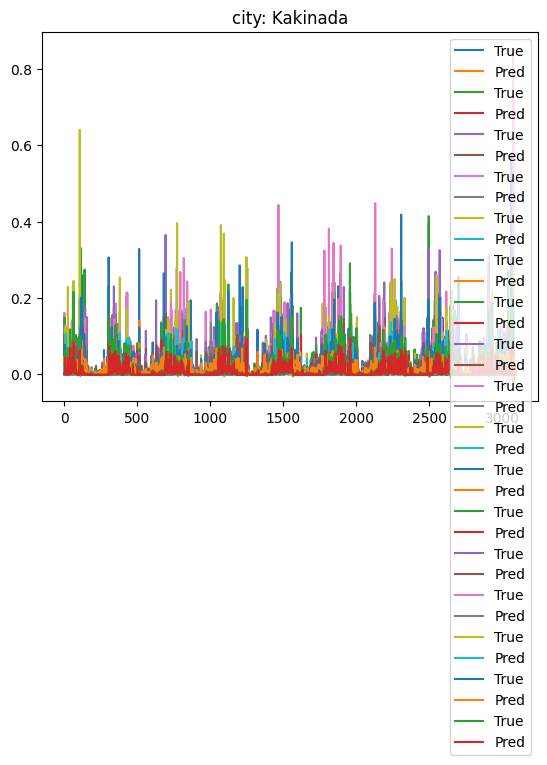

In [100]:
for city in weather_df['city_name'].unique():

    print(f"Starting for city: {city} \n")
    city_weather_df = split_dataframe(df=weather_df, city_name=city)

    city_lag_df = create_lag_dataframe(df=city_weather_df, scaler=scaler, n_steps=LOOKBACK)

    X, y = create_X_y(df=city_lag_df)

    X_train, X_test, y_train, y_test = get_train_test_data(X=X, y=y, train_size=0.75)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    print(f"Dataset created")

    train_dataloader, test_dataloader = create_dataloader(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                                                          batch_size=BATCH_SIZE)
    print(f"DataLoader created")

    model = LSTMModel(input_size=1, hidden_size=8, num_layers=2, output_size=1)
    print(f"Model Initialized")

    loss_fn, optimizer = set_loss_optimizer(model=model)
    print(f"loss function and optimizer set")

    print(f"Starting training model for city: {city} \n")
    results = train_model(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn,
                          optimizer=optimizer, epochs=EPOCHS, device=device)

    print(f"Model trained for city: {city} \n")

    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test.to(device)).to('cpu').numpy()

    plt.plot(y_test, label='True')
    plt.plot(y_pred, label='Pred')
    plt.legend()
    plt.title(f"city: {city}")

    save_model(model=model, city=city)

    print("---------------------------------------------------------------\n")
    print("---------------------------------------------------------------\n")

In [26]:
def load_model(city: str, device: torch.device = device):

    model_path = Path("models")

    model_name = f"{city}_model.pth"

    model_save_path = model_path / model_name

    model_state_dict = torch.load(f=model_save_path)

    model = LSTMModel(input_size=1, hidden_size=8, num_layers=2, output_size=1)

    model.load_state_dict(model_state_dict)

    return model.to(device)

In [30]:
chennai_model = load_model(city='Chennai', device=device)
chennai_model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-3.3006],
                      [-0.9628],
                      [-2.0379],
                      [-1.8204],
                      [-3.1147],
                      [-1.9952],
                      [ 0.2596],
                      [-3.7441],
                      [-1.9801],
                      [-0.9593],
                      [-2.9899],
                      [-3.7084],
                      [-2.4497],
                      [-2.1311],
                      [-0.3658],
                      [-2.3374],
                      [ 1.7920],
                      [-0.5699],
                      [ 2.1919],
                      [-2.4923],
                      [ 1.5043],
                      [-1.5241],
                      [ 1.1333],
                      [ 1.8876],
                      [-3.2936],
                      [-1.0332],
                      [-2.1447],
                      [-2.6229],
                      [-3.0252],
        

In [182]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

def weather_api_response(city_name):
    """
        API call to get data for model prediction
        -----------------------------------------
        Returns pandas.DataFrame
    """

    city_details = {
        "Chennai" : [13.08, 80.27],
        "Mayiladuthurai" : [11.10, 79.65],
        "Thoothukudi" : [8.76, 78.13],
        "Nagercoil" : [8.18, 77.41],
        "Thiruvananthapuram": [8.53, 76.94],
        "Kollam": [8.89, 76.61],
        "Kochi": [9.95, 76.26],
        "Kozhikode": [11.26, 75.77],
        "Kannur": [11.87, 75.37],
        "Visakhapatnam": [17.69, 83.23],
        "Nellore": [14.44, 79.98],
        "Mangaluru": [13.01, 74.92],
        "Udupi": [13.34, 74.74],
        "Mumbai": [19.09, 72.84],
        "Daman": [20.40, 72.83],
        "Alappuzha": [9.50, 76.34],
        "Kakinada": [16.98, 82.25]
    }
    try:
        cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
        retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
        openmeteo = openmeteo_requests.Client(session = retry_session)
    except:
        print("Weather API client error")
    try:
        city_lat = city_details[city_name][0]
        city_long = city_details[city_name][1]
    except KeyError:
        print("City prediction not available")

    url = "https://archive-api.open-meteo.com/v1/archive"
    current_date = datetime.today() - timedelta(days=3)
    lookback_date = datetime.today() - timedelta(days=62)
    params = {
        "latitude": city_lat,
        "longitude": city_long,
        "start_date": lookback_date.strftime('%Y-%m-%d'),
        "end_date": current_date.strftime('%Y-%m-%d'),
        "daily": ["precipitation_sum"],
        "timezone": "Asia/Kolkata"
    }
    try:
        responses = openmeteo.weather_api(url, params=params)
    except:
        print("Weather API request error")

    response = responses[0]
    daily = response.Daily()
    daily_data = {"date": pd.date_range(
                            start = pd.to_datetime(daily.Time(), unit = "s"),
                            end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
                            freq = pd.Timedelta(seconds = daily.Interval()),
                            inclusive = "left"
                        ).strftime('%Y-%m-%d'),
                "city_name" : city_name
                }

    daily_data["precipitation_sum"] = daily.Variables(0).ValuesAsNumpy()

    daily_df = pd.DataFrame(data = daily_data)

    return daily_df

In [187]:
def model_prediction(model: nn.Module, date_diff: int, X: torch.Tensor, df: pd.DataFrame):

    prediction = model(X.to(device))

    date = datetime.now() - timedelta(days=3) + timedelta(days=date_diff)

    df.loc[len(df)] = [date, prediction.item()]

    X_new = torch.cat((X[:, 1:].to(device), prediction.unsqueeze(0).to(device)), dim=1)

    return df, X_new


In [194]:
def daily_prediction(model: nn.Module, date: datetime, city: str) -> pd.DataFrame:

    rainfall_df = pd.DataFrame(data=None, columns=['date',          'precipitation_sum'])

    df = weather_api_response(city_name=city)

    current_date = datetime.now() - timedelta(days=3)

    date_diff = (date - current_date).days + 1

    city_weather_df = split_dataframe(df=df, city_name=city)

    city_lag_df = create_lag_dataframe(df=city_weather_df, scaler=scaler, n_steps=59)

    df_as_np = city_lag_df.to_numpy()

    X = deepcopy(np.flip(df_as_np, axis=1))

    X = X.reshape((-1, 60, 1))
    X = torch.tensor(X, dtype=torch.float)

    for i in range(1, date_diff+1):

        rainfall_df, X = model_prediction(model=model, date_diff=i, X=X, df=rainfall_df)

    return rainfall_df

In [195]:
prediction_df = daily_prediction(chennai_model, date=datetime(2024, 5, 1), city='Chennai')
prediction_df

,date,precipitation_sum
0,2024-04-26 02:41:45.617495,0.001429
1,2024-04-27 02:41:45.621013,0.002595
2,2024-04-28 02:41:45.624026,0.003481
3,2024-04-29 02:41:45.628016,0.004236
4,2024-04-30 02:41:45.631269,0.004916
5,2024-05-01 02:41:45.636264,0.005558


In [197]:
scaler.inverse_transform([[prediction_df['precipitation_sum'][0]]])

array([[0.63618038]])

In [3]:
warnings.filterwarnings('ignore')

In [4]:
from utils import prediction

results = {"flood": None, "drought" : None}

date = datetime(2024,5,1)
prediction_df = prediction(city_name='Chennai', date=date)
prediction_df

,date,precipitation_sum
0,2024-04-26 10:59:38.624006,0.004219
1,2024-04-27 10:59:38.626008,0.007152
2,2024-04-28 10:59:38.629008,0.008726
3,2024-04-29 10:59:38.631512,0.009611
4,2024-04-30 10:59:38.635042,0.010144
5,2024-05-01 10:59:38.637073,0.010539


In [11]:
flood_cnt = 0
for i in range(len(prediction_df)):
    if prediction_df['precipitation_sum'][i] > 10:
        flood_cnt += 1

drought_cnt = 0
for i in range(len(prediction_df)):
    if prediction_df['precipitation_sum'][i] < 1:
        drought_cnt += 1

if flood_cnt >= len(prediction_df) * 0.8:
    results['flood'] = True

if drought_cnt <= len(prediction_df) * 0.9:
    results['drought'] = True

SyntaxError: expected ':' (3487308801.py, line 7)